# Clean dataset using influence functions and neural networks

This notebook shows how to calculate influences on a NN model using pyDVL for an arbitrary dataset.

It uses the wine dataset from sklearn: given a set of 13 different input parameters regarding a particular bottle, each related to some physical property (e.g. concentration of magnesium, malic acidity, alcoholic percentage, etc), the model will need to predict to which of 3 classes the wine belongs to. For more details, please refer to the [sklearn documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-recognition-dataset).

Let's start by loading the imports, the dataset and splitting it into train, validation and test sets. We will use a large test set to have a less noisy estimate of the average influence.

In [1]:
from valuation.utils.dataset import load_wine_dataset
import matplotlib.pyplot as plt
import torch
from valuation.influence.model_wrappers import TorchNeuralNetwork
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

train_ds, val_ds, test_ds = load_wine_dataset(train_size=0.3, test_size=0.6)

## Fit a neural network to the data

We will train a 2-layer neural network. PyDVL has some convenience wrappers to initialize a pytorch NN. If you already have a model loaded and trained, you can skip this section.

In [2]:
feature_dimension = train_ds[0].shape[1]
unique_classes = np.unique(np.concatenate((train_ds[1], test_ds[1])))
num_classes = len(unique_classes)
network_size = [16, 16]

num_epochs = 300
lr = 0.005
weight_decay = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nn = TorchNeuralNetwork(feature_dimension, num_classes, network_size)
nn.to(device)
optimizer = Adam(params=nn.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_loss, val_loss = nn.fit(
    x_train=train_ds[0],
    y_train=train_ds[1],
    x_val=val_ds[0],
    y_val=val_ds[1],
    loss=F.cross_entropy,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    batch_size=16,
)

Let's check that the training has found a stable minimum by plotting the train and validation loss

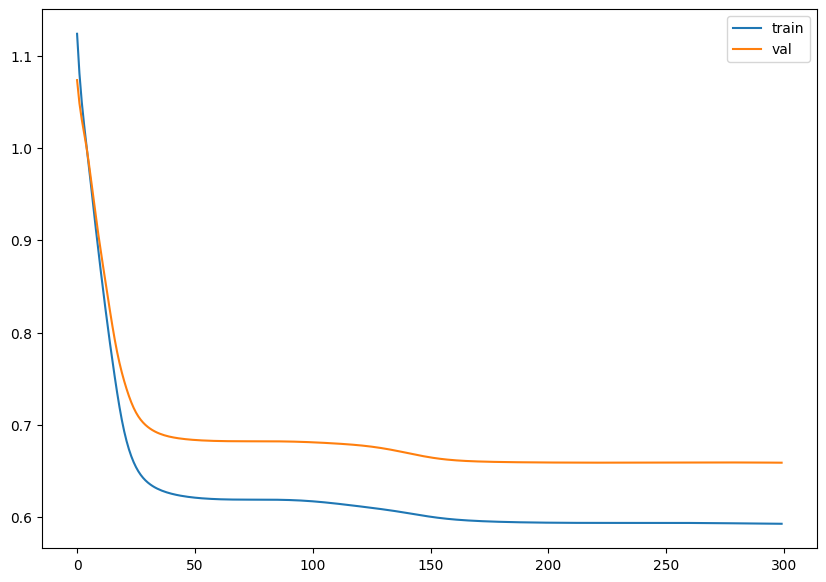

In [3]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.show()

Since it is a classification problem, let's also take a look at the confusion matrix on the test set

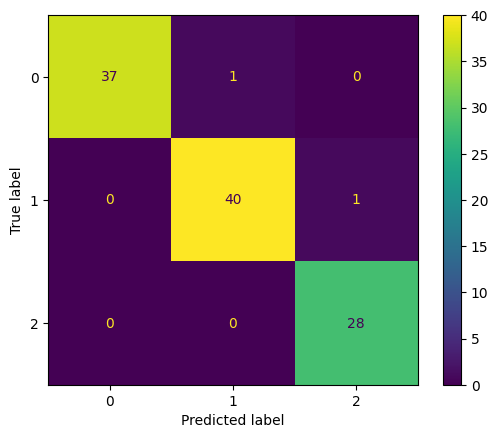

In [4]:
pred_y_test = np.argmax(nn(test_ds[0]).detach(), axis=1)

cm = confusion_matrix(test_ds[1], pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

And let's compute the f1 score of the model

In [5]:
f1_score(test_ds[1], pred_y_test, average="weighted")

0.9813280865715691

Let's now move to calculating influences of each point on the total score.

## Calculating influences for small neural networks

The following cell calculates the influences of each training data-point on the neural network error. 
The calculation of the Hessian matrix (necessary to calculate the influences) can be quite numerically challenging, but there are some techniques to speed up the calculation. PyDVL allows to use the full method ("direct") or the conjugate gradient method ("cg"). The first one should be used only for very small networks (like our current example), while for bigger ones "cg" is advisable.

In [6]:
from valuation.influence.general import influences

inversion_method = "direct"  # cg for big networks

train_influences = influences(
    nn, F.cross_entropy, *train_ds, *test_ds, inversion_method=inversion_method
)

the returned matrix, train_influences, has a quantity of columns equal to the points in the training set, and a number of rows equal to the points in the test set. At each element $a_{i,j}$ it stores the influence that training point $j$ has on the classification of test point $i$.

If we take the average across every column of the influences matrix, we obtain an estimate of the overall influence of a training point on the total accuracy of the network.

In [7]:
mean_train_influences = np.mean(train_influences, axis=0)

The following histogram shows that there are big differences in score within the training set (notice the log-scale on the y axis).

Text(0, 0.5, 'number of points')

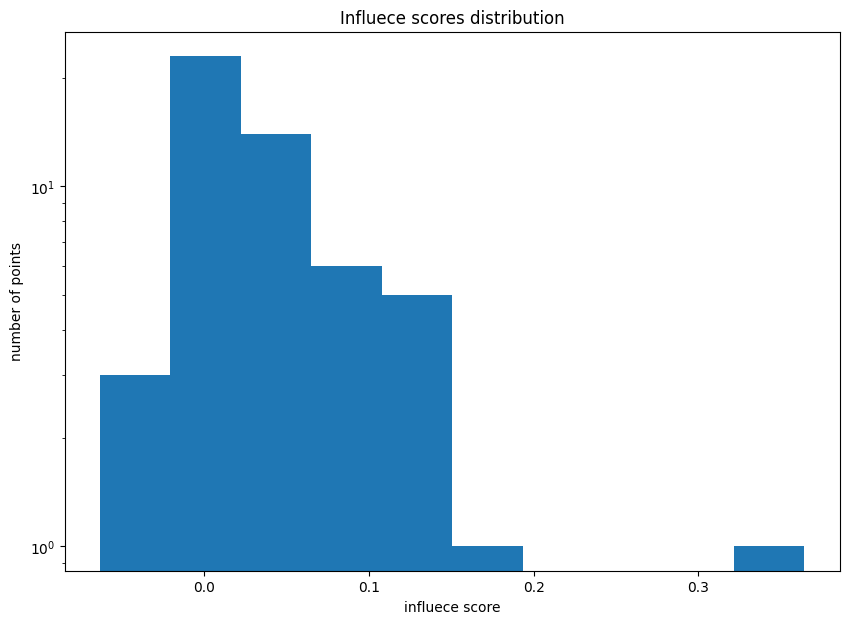

In [8]:
plt.figure(figsize=(10, 7))
plt.hist(mean_train_influences, log=True)
plt.title("Influece scores distribution")
plt.xlabel("influece score")
plt.ylabel("number of points")

# Conjugate Gradient and beyond in PyDVL

This was a quick introduction to influence functions and how they could help you in your projects. Give it a try! For example you can try with a bigger neural network and using conjugate gradient for the calculation of influence functions. This can me done in the following way 

In [9]:
train_influences = influences(
    nn,
    F.cross_entropy,
    *train_ds,
    *test_ds,
    inversion_method="cg",
    inversion_method_kwargs={"max_iterations": 10, "max_step_size": 0.01}
)

where max_iterations and max_step_size and yet another set of hyperparameters that need to be tuned to obtain a good estimate.

Finally, despite their speed and simplicity, influence functions are known to be a very noisy estimator of data quality, as pointed out in the paper ["Influence functions in deep learning are fragile"](https://arxiv.org/abs/2006.14651). The size of the network, the weight decay, the inversion method used for calculating influences, the size of the test set: they all add up to the total amount of noise in the influence values. Experiments may therefore give quantitative and qualitative different results if not averaged across several realisations. Shapley values, on the contrary, have shown to be a more robust, but this comes at the cost of high computational requirements. PyDVL employs several parallelization and caching techniques to optimize such calculations.